## Load packages

In [111]:
import  warnings
warnings.simplefilter('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind

from sklearn.preprocessing import OneHotEncoder

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from bayes_opt import BayesianOptimization
from sklearn.model_selection import KFold, cross_val_score

from sklearn.metrics import roc_curve

%matplotlib inline

## Load datasets

In [2]:
email = pd.read_csv('../data/email_table.csv')
email.head()

,email_id,email_text,email_version,hour,weekday,user_country,user_past_purchases
0,85120,short_email,personalized,2,Sunday,US,5
1,966622,long_email,personalized,12,Sunday,UK,2
2,777221,long_email,personalized,11,Wednesday,US,2
3,493711,short_email,generic,6,Monday,UK,1
4,106887,long_email,generic,14,Monday,US,6


In [3]:
email.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 7 columns):
email_id               100000 non-null int64
email_text             100000 non-null object
email_version          100000 non-null object
hour                   100000 non-null int64
weekday                100000 non-null object
user_country           100000 non-null object
user_past_purchases    100000 non-null int64
dtypes: int64(3), object(4)
memory usage: 5.3+ MB


In [4]:
email_opened = pd.read_csv('../data/email_opened_table.csv')
email_opened.head()

,email_id
0,284534
1,609056
2,220820
3,905936
4,164034


In [5]:
email_opened.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10345 entries, 0 to 10344
Data columns (total 1 columns):
email_id    10345 non-null int64
dtypes: int64(1)
memory usage: 80.9 KB


In [6]:
link_clicked = pd.read_csv('../data/link_clicked_table.csv')
link_clicked.head()

,email_id
0,609056
1,870980
2,935124
3,158501
4,177561


In [7]:
link_clicked.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2119 entries, 0 to 2118
Data columns (total 1 columns):
email_id    2119 non-null int64
dtypes: int64(1)
memory usage: 16.6 KB


## Data preprocessing
### Merge three datasets

In [49]:
email_opened['opened']=1
link_clicked['clicked']=1
data=pd.merge(left=email, right=email_opened, how='left', on='email_id')
data=pd.merge(left=data, right=link_clicked, how='left', on='email_id')
data=data.fillna(0)
data['opened'] = data['opened'].astype(int)
data['clicked'] = data['clicked'].astype(int)
data.head()

,email_id,email_text,email_version,hour,weekday,user_country,user_past_purchases,opened,clicked
0,85120,short_email,personalized,2,Sunday,US,5,0,0
1,966622,long_email,personalized,12,Sunday,UK,2,1,1
2,777221,long_email,personalized,11,Wednesday,US,2,0,0
3,493711,short_email,generic,6,Monday,UK,1,0,0
4,106887,long_email,generic,14,Monday,US,6,0,0


### Categorical feature engineering
#### Transform string into number

In [110]:
## set short_email = 0, and long_email =1
data['text']=np.where(data.email_text == 'short_email',0,1)
#del data["email_text"]

## set personalized = 1, and generic =0
data['is_personal']=np.where(data.email_version == 'personalized',0,1)
#del data["email_version"]

## use number to replace the string in weekday
weekday_index = {"Monday":1,"Tuesday":2,"Wednesday":3,"Thursday":4,"Friday":5,"Saturday":6,"Sunday":7}
data["weekday_index"] = data.weekday.map(weekday_index)

data.head()

,email_id,email_text,email_version,hour,weekday,user_country,user_past_purchases,opened,clicked,text,is_personal,weekday_index,ES,FR,UK,US
0,85120,short_email,personalized,2,Sunday,US,5,0,0,0,0,7,0,0,0,1
1,966622,long_email,personalized,12,Sunday,UK,2,1,1,1,0,7,0,0,1,0
2,777221,long_email,personalized,11,Wednesday,US,2,0,0,1,0,3,0,0,0,1
3,493711,short_email,generic,6,Monday,UK,1,0,0,0,1,1,0,0,1,0
4,106887,long_email,generic,14,Monday,US,6,0,0,1,1,1,0,0,0,1


#### One hot encoder for user_country

In [51]:
## one-hot encoder for user_country
hot = OneHotEncoder()
country= hot.fit_transform(data[['user_country']])
country.df = pd.DataFrame(country.toarray(), columns=hot.get_feature_names(['user_country']))
country.df.shape

data=pd.concat( [data, country.df],axis=1)
data.rename(columns={'user_country_ES':'ES','user_country_FR':'FR','user_country_UK':'UK','user_country_US':'US'},
            inplace=True)

data['ES'] = data['ES'].astype(int)
data['FR'] = data['FR'].astype(int)
data['UK'] = data['UK'].astype(int)
data['US'] = data['US'].astype(int)

data.head()


,email_id,email_text,email_version,hour,weekday,user_country,user_past_purchases,opened,clicked,text,is_personal,weekday_index,ES,FR,UK,US
0,85120,short_email,personalized,2,Sunday,US,5,0,0,0,0,7,0,0,0,1
1,966622,long_email,personalized,12,Sunday,UK,2,1,1,1,0,7,0,0,1,0
2,777221,long_email,personalized,11,Wednesday,US,2,0,0,1,0,3,0,0,0,1
3,493711,short_email,generic,6,Monday,UK,1,0,0,0,1,1,0,0,1,0
4,106887,long_email,generic,14,Monday,US,6,0,0,1,1,1,0,0,0,1


## Data visualization
### visualization of email_text

Short emails have higher click through rate

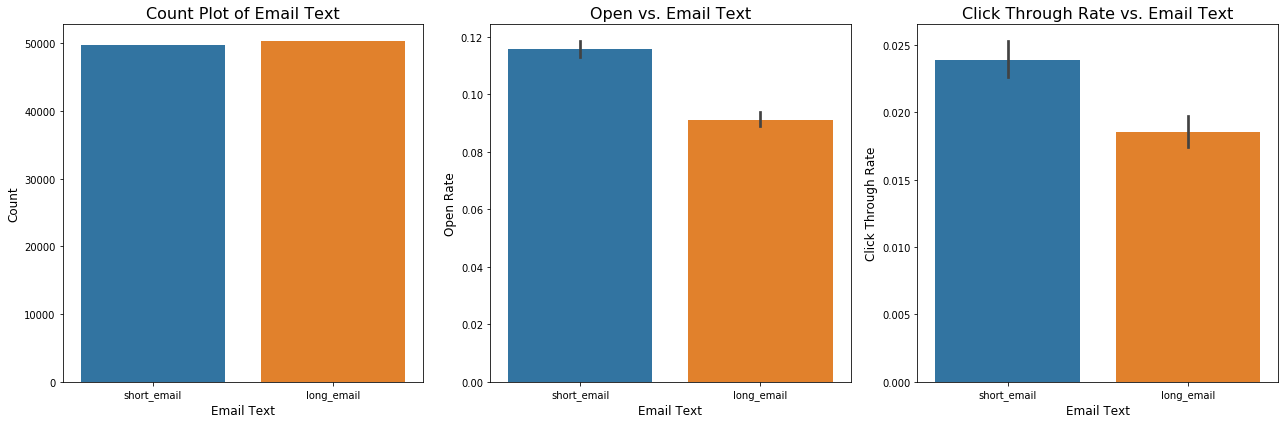

In [10]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))
sns.countplot(x='email_text', data=data, ax=ax[0])
ax[0].set_xlabel('Email Text', fontsize=12)
ax[0].set_ylabel('Count', fontsize=12)
ax[0].set_title('Count Plot of Email Text', fontsize=16)

sns.barplot(x='email_text', y='opened', data=data, ax=ax[1])
ax[1].set_xlabel('Email Text', fontsize=12)
ax[1].set_ylabel('Open Rate', fontsize=12)
ax[1].set_title('Open vs. Email Text', fontsize=16)
plt.tight_layout()

sns.barplot(x='email_text', y='clicked', data=data, ax=ax[2])
ax[2].set_xlabel('Email Text', fontsize=12)
ax[2].set_ylabel('Click Through Rate', fontsize=12)
ax[2].set_title('Click Through Rate vs. Email Text', fontsize=16)
plt.tight_layout()



plt.show()

#### Visualization of email_version

Emails with personalization version have higher click through rate

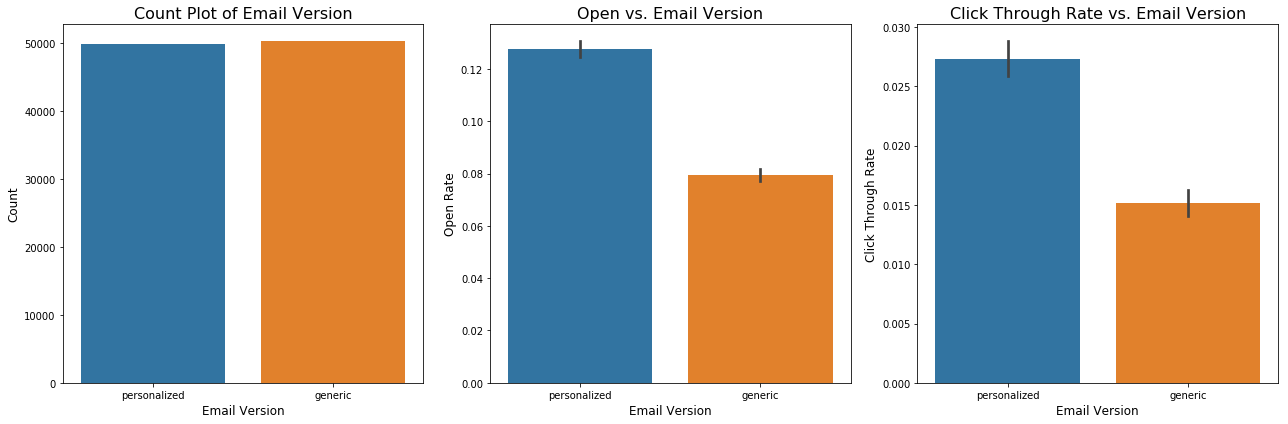

In [11]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))
sns.countplot(x='email_version', data=data, ax=ax[0])
ax[0].set_xlabel('Email Version', fontsize=12)
ax[0].set_ylabel('Count', fontsize=12)
ax[0].set_title('Count Plot of Email Version', fontsize=16)

sns.barplot(x='email_version', y='opened', data=data, ax=ax[1])
ax[1].set_xlabel('Email Version', fontsize=12)
ax[1].set_ylabel('Open Rate', fontsize=12)
ax[1].set_title('Open vs. Email Version', fontsize=16)
plt.tight_layout()

sns.barplot(x='email_version', y='clicked', data=data, ax=ax[2])
ax[2].set_xlabel('Email Version', fontsize=12)
ax[2].set_ylabel('Click Through Rate', fontsize=12)
ax[2].set_title('Click Through Rate vs. Email Version', fontsize=16)
plt.tight_layout()

plt.show()

#### Visualization of hour

Emails sended from 9 to 18 have a little higher click through rate. The high click through rate from 23 to 24 may be caused by quite fewer samples.

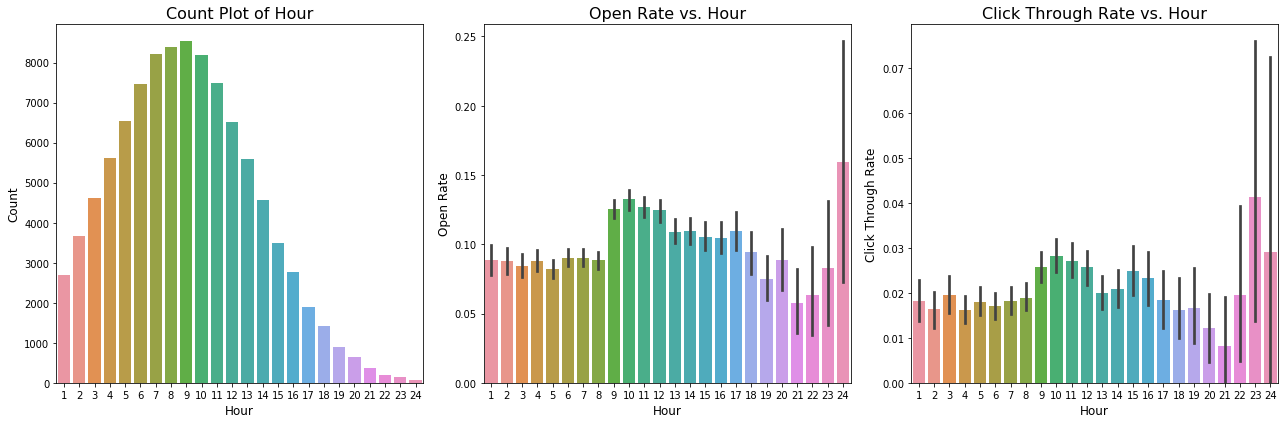

In [12]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))
sns.countplot(x='hour', data=data, ax=ax[0])
ax[0].set_xlabel('Hour', fontsize=12)
ax[0].set_ylabel('Count', fontsize=12)
ax[0].set_title('Count Plot of Hour', fontsize=16)

sns.barplot(x='hour', y='opened', data=data, ax=ax[1])
ax[1].set_xlabel('Hour', fontsize=12)
ax[1].set_ylabel('Open Rate', fontsize=12)
ax[1].set_title('Open Rate vs. Hour', fontsize=16)
plt.tight_layout()

sns.barplot(x='hour', y='clicked', data=data, ax=ax[2])
ax[2].set_xlabel('Hour', fontsize=12)
ax[2].set_ylabel('Click Through Rate', fontsize=12)
ax[2].set_title('Click Through Rate vs. Hour', fontsize=16)
plt.tight_layout()

plt.show()

#### Visualization of weekday
Higher click through rate occurs from Monday to Thursday, lowest click through rate occurs on Friday.

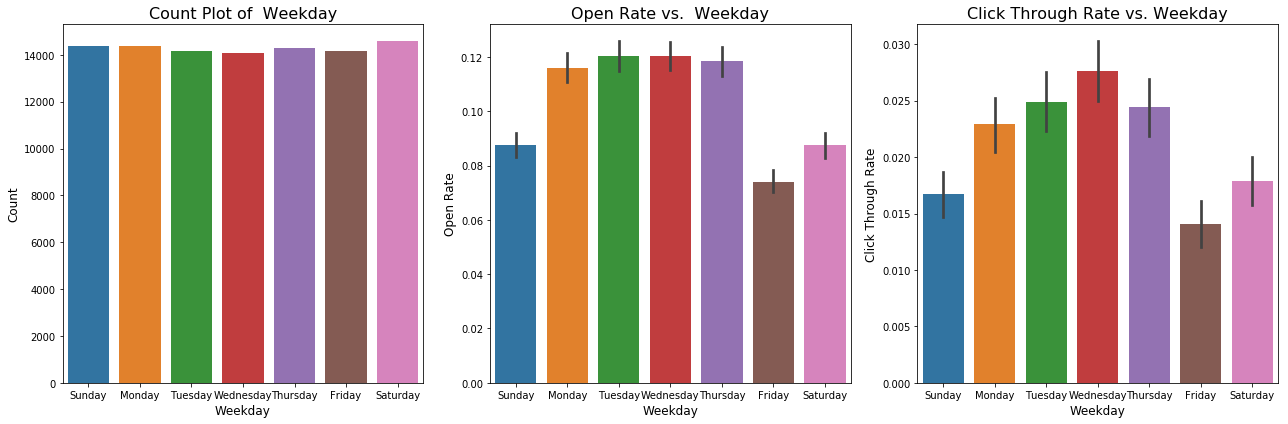

In [14]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))
sns.countplot(x='weekday', order=['Sunday','Monday','Tuesday','Wednesday','Thursday','Friday','Saturday'],
              data=data, ax=ax[0])
ax[0].set_xlabel('Weekday', fontsize=12)
ax[0].set_ylabel('Count', fontsize=12)
ax[0].set_title('Count Plot of  Weekday', fontsize=16)

sns.barplot(x='weekday', y='opened', order=['Sunday','Monday','Tuesday','Wednesday','Thursday','Friday','Saturday'],
            data=data, ax=ax[1])
ax[1].set_xlabel('Weekday', fontsize=12)
ax[1].set_ylabel('Open Rate', fontsize=12)
ax[1].set_title('Open Rate vs.  Weekday', fontsize=16)
plt.tight_layout()

sns.barplot(x='weekday', y='clicked',  order=['Sunday','Monday','Tuesday','Wednesday','Thursday','Friday','Saturday'],
            data=data, ax=ax[2])
ax[2].set_xlabel('Weekday', fontsize=12)
ax[2].set_ylabel('Click Through Rate', fontsize=12)
ax[2].set_title('Click Through Rate vs. Weekday', fontsize=16)
plt.tight_layout()

plt.show()

#### Visualization of country
Emails sended to US- and UK- users have high click through rate, those sended to FR- and ES- users have low click through rate. 

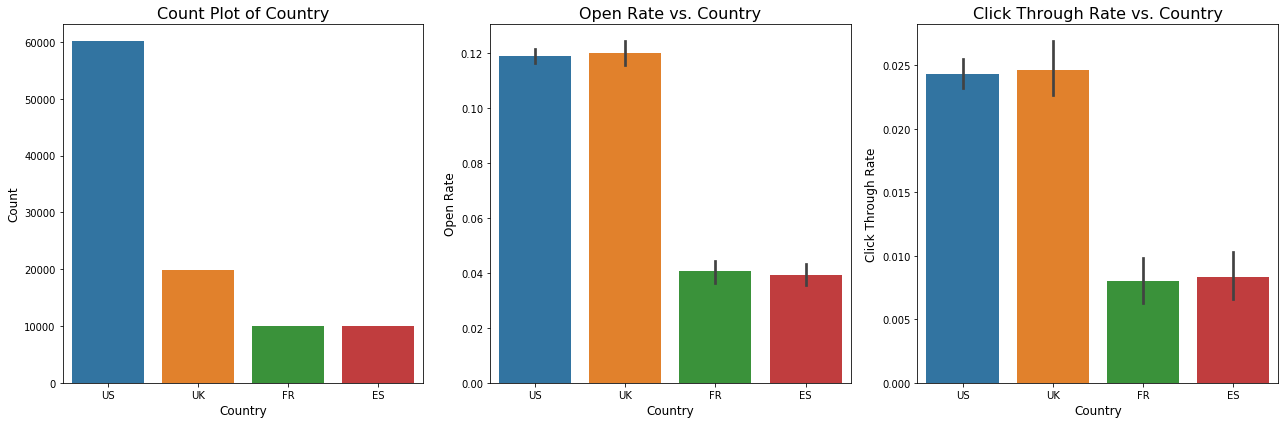

In [17]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))
sns.countplot(x='user_country', data=data, ax=ax[0])
ax[0].set_xlabel('Country', fontsize=12)
ax[0].set_ylabel('Count', fontsize=12)
ax[0].set_title('Count Plot of Country', fontsize=16)

sns.barplot(x='user_country', y='opened', data=data, ax=ax[1])
ax[1].set_xlabel('Country', fontsize=12)
ax[1].set_ylabel('Open Rate', fontsize=12)
ax[1].set_title('Open Rate vs. Country', fontsize=16)
plt.tight_layout()

sns.barplot(x='user_country', y='clicked', data=data, ax=ax[2])
ax[2].set_xlabel('Country', fontsize=12)
ax[2].set_ylabel('Click Through Rate', fontsize=12)
ax[2].set_title('Click Through Rate vs. Country', fontsize=16)
plt.tight_layout()

plt.show()

#### Visualization of past purchases
The more items a certain user purchased previously, the more likely that user will open the email or click the link. But the sample sizes for those users purchased more previously are quite small.

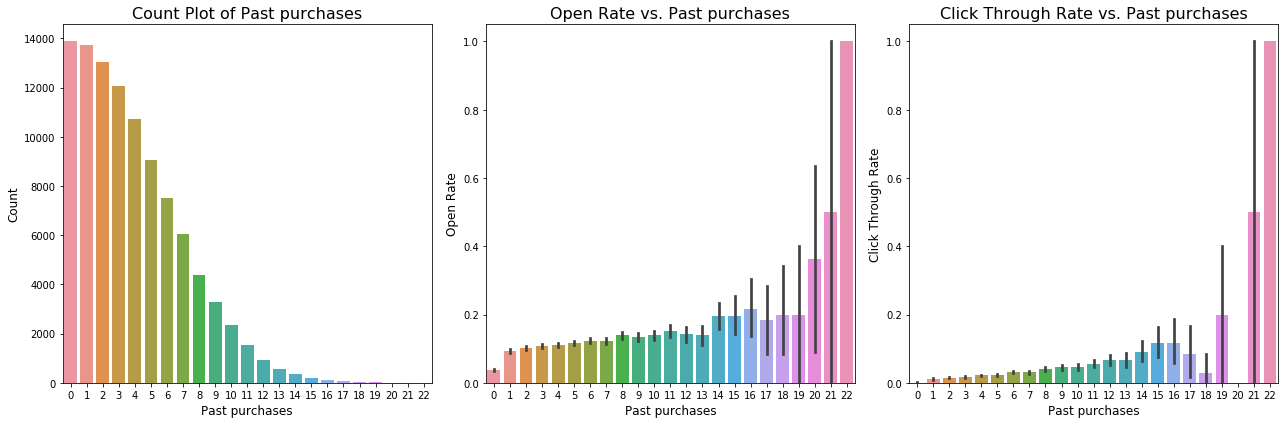

In [18]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))
sns.countplot(x='user_past_purchases', data=data, ax=ax[0])
ax[0].set_xlabel('Past purchases', fontsize=12)
ax[0].set_ylabel('Count', fontsize=12)
ax[0].set_title('Count Plot of Past purchases', fontsize=16)

sns.barplot(x='user_past_purchases', y='opened', data=data, ax=ax[1])
ax[1].set_xlabel('Past purchases', fontsize=12)
ax[1].set_ylabel('Open Rate', fontsize=12)
ax[1].set_title('Open Rate vs. Past purchases', fontsize=16)
plt.tight_layout()

sns.barplot(x='user_past_purchases', y='clicked', data=data, ax=ax[2])
ax[2].set_xlabel('Past purchases', fontsize=12)
ax[2].set_ylabel('Click Through Rate', fontsize=12)
ax[2].set_title('Click Through Rate vs. Past purchases', fontsize=16)
plt.tight_layout()

plt.show()

## Data modeling
### Split dataset into train, validation and test

In [116]:
df1=data[['hour','user_past_purchases']]
df2=data.loc[:, 'opened':'US']
df=pd.concat([df1, df2], axis=1)
#df.head()

df_copy=df
X=df_copy.drop(columns=['clicked','opened'])
Y=df.clicked

## split dataset into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=2019)

## split X_train into training and validation 
X_train_2, X_val, y_train_2, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=2019)


### Tune RandomForestClassifier with BayesianOpitmization
#### RandomForestClassifier baseline model

In [118]:
# Instantiate an RandomForestClassifier with default hyperparameter settings
rf = RandomForestClassifier(class_weight='balanced') ## Since base rate of cliked=1 is very rare, data should be balanced

# compute a baseline to beat with hyperparameter optimization 
rf_baseline_train = cross_val_score(rf, X_train_2, y_train_2, scoring='roc_auc').mean()
rf_baseline_val = cross_val_score(rf, X_val, y_val, scoring='roc_auc').mean()

print('train_rf_baseline ROC_AUC: {0:.3}'.format(rf_baseline_train))
print('val_rf_baseline ROC_AUC: {0:.3}'.format(rf_baseline_val))

train_rf_baseline ROC_AUC: 0.526
val_rf_baseline ROC_AUC: 0.544


#### Set up the search space 
Three hyperparameters: n_estimators, max_depth and min_samples_split will be tuned

In [122]:
def rf_evaluate( n_estimators, max_depth, min_samples_split): 
    rf_params = {  'n_estimators': int(n_estimators),                                                              
                   'max_depth': int(max_depth),
                   'min_samples_split':int(min_samples_split), 
                   'n_jobs':-1, 
                   'random_state':42 
               }
     # Used around 1000 boosting rounds in the full model
    cv_result= cross_val_score(RandomForestClassifier(**rf_params),  ## ** unpack params for the function call
               X=X_train_2, 
               y=y_train_2, 
               cv=4,
               scoring='roc_auc',
               n_jobs=-1).mean()   
    return cv_result

rf_params = {"n_estimators": (10, 300),
                  "max_depth": (3, 20),
                  "min_samples_split": (2, 10)}


rf_bo = BayesianOptimization(rf_evaluate , rf_params)

In [123]:
rf_bo.maximize(init_points=5, n_iter=5, acq='ei')

|   iter    |  target   | max_depth | min_sa... | n_esti... |
-------------------------------------------------------------
|  1        |  0.7243   |  3.072    |  6.038    |  162.2    |
|  2        |  0.6568   |  18.18    |  7.989    |  162.3    |
|  3        |  0.7334   |  5.185    |  9.403    |  117.3    |
|  4        |  0.7344   |  6.182    |  8.547    |  165.9    |
|  5        |  0.6024   |  17.32    |  3.106    |  10.7     |
|  6        |  0.7241   |  3.0      |  10.0     |  300.0    |
|  7        |  0.7238   |  3.0      |  10.0     |  226.9    |
|  8        |  0.7246   |  3.0      |  10.0     |  166.8    |
|  9        |  0.7241   |  3.0      |  2.0      |  70.25    |
|  10       |  0.7054   |  11.32    |  2.0      |  195.6    |


In [124]:
## get the best parameters 
rf_params = rf_bo.max['params']

print(rf_params)

{'max_depth': 6.181658149498906, 'min_samples_split': 8.547467628246167, 'n_estimators': 165.85824302078993}


In [125]:
rf_tuned = RandomForestClassifier(max_depth=6, min_samples_split=8, n_estimators= 165)
rf_tuned = rf_tuned.fit(X_train_2, y_train_2)

rf_tuned_train_ROC_AUC = cross_val_score(rf_tuned, X_train_2, y_train_2, scoring='roc_auc').mean()
rf_tuned_val_ROC_AUC = cross_val_score(rf_tuned, X_val, y_val, scoring='roc_auc').mean()

print('train_rf_baseline ROC_AUC: {0:.3}'.format(rf_baseline_train))
print('train_rf_tuned ROC_AUC: {0:.3}'.format(rf_tuned_train_ROC_AUC))

print(' ')

print('val_rf_baseline ROC_AUC: {0:.3}'.format(rf_baseline_val))
print('val_rf_tuned ROC_AUC: {0:.3}'.format(rf_tuned_val_ROC_AUC))

train_rf_baseline ROC_AUC: 0.526
train_rf_tuned ROC_AUC: 0.73
 
val_rf_baseline ROC_AUC: 0.544
val_rf_tuned ROC_AUC: 0.731


### Evaluate the tuned RandomForestClassifier on testing dataset

In [126]:
## predict on the hold out set: test set

## basiline RandomForest with default parameters
rf_baseline_test = cross_val_score(rf, X_test, y_test, scoring='roc_auc').mean()

## tuned RandomForest 
rf_tuned_test_ROC_AUC = cross_val_score(rf_tuned, X_test, y_test, scoring='roc_auc').mean()

print('test_rf_baseline ROC_AUC: {0:.3}'.format(rf_baseline_test))
print('test_rf_tuned ROC_AUC: {0:.3}'.format(rf_tuned_test_ROC_AUC ))

test_rf_baseline ROC_AUC: 0.552
test_rf_tuned ROC_AUC: 0.724


Plot ROC_AUC

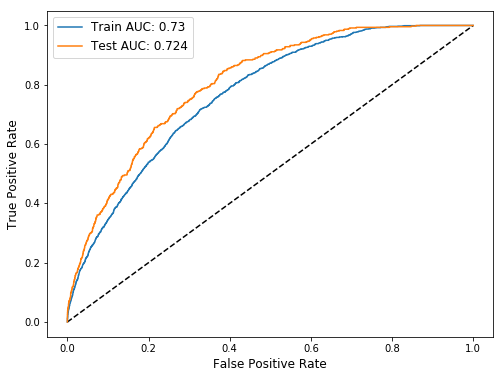

In [139]:
# ROC curves
rf_tuned.fit(X_test,y_test)
y_test_proba=rf_tuned.predict_proba(X_test)
test_fpr, test_tpr, test_thresholds = roc_curve(y_test, y_test_proba[:,1])

rf_tuned.fit(X_train_2,y_train_2)
y_train_proba=rf_tuned.predict_proba(X_train_2)
train_fpr, train_tpr, train_thresholds_2 = roc_curve(y_train_2, y_train_proba[:,1])

fig, ax = plt.subplots(figsize=(8, 6))
ax.plot([0, 1], [0, 1], 'k--') # dashed diagonal
ax.plot(train_fpr, train_tpr, label='Train AUC: ' + str('{0:.3}'.format(rf_tuned_train_ROC_AUC )))
ax.plot(test_fpr, test_tpr, label='Test AUC: ' + str('{0:.3}'.format(rf_tuned_test_ROC_AUC )))
ax.set_xlabel('False Positive Rate', fontsize=12)
ax.set_ylabel('True Positive Rate', fontsize=12)
ax.legend(fontsize=12)
plt.show()

### Feature importance

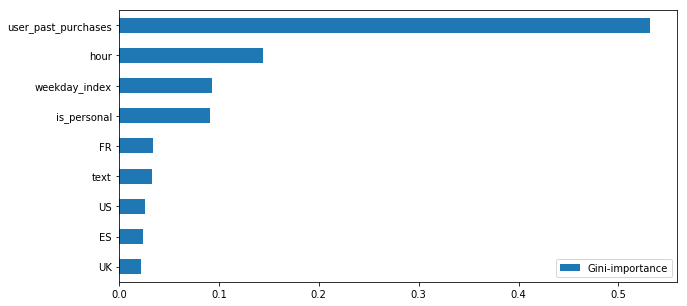

In [128]:
rf_fscores=pd.DataFrame(rf_tuned.feature_importances_)

feats = {} # a dict to hold feature_name: feature_importance
for feature, importance in zip(X_train_2.columns, rf_tuned.feature_importances_):
    feats[feature] = importance #add the name/value pair 

importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-importance'})
importances.sort_values(by='Gini-importance', ascending=True).plot(kind='barh', figsize=(10,5))